In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import matplotlib as mp
import matplotlib.animation as animation
import IPython


MASS = 0.600 # mass of the quadrotor
INERTIA = 0.15 # inertia of the quadrotor
        
LENGTH = 0.2 # length of the quadrotor
        
GRAVITY=9.81 #gravity constant

DELTA_T = 0.01 #integration step
        
NUMBER_STATES = 6 # number of states
NUMBER_CONTROLS = 2 # number of controls
        
            
def get_next_state(z,u):
    """
    Inputs:
    z: state of the quadrotor as a numpy array (x, vx, y, vy, theta, omega)
    u: control as a numpy array (u1, u2)

    Output:
    the new state of the quadrotor as a numpy array
    """
    x = z[0]
    vx = z[1]
    y = z[2]
    vy = z[3]
    theta = z[4]
    omega = z[5]

    dydt = np.zeros([NUMBER_STATES,])
    dydt[0] = vx
    dydt[1] = (-(u[0] + u[1]) * np.sin(theta)) / MASS
    dydt[2] = vy
    dydt[3] = ((u[0] + u[1]) * np.cos(theta) - MASS * GRAVITY) / MASS
    dydt[4] = omega
    dydt[5] = (LENGTH * (u[0] - u[1])) / INERTIA

    z_next = z + dydt * DELTA_T

    return z_next


    
def simulate(z0, controller, horizon_length, disturbance = False):
    """
    This function simulates the quadrotor for horizon_length steps from initial state z0

    Inputs:
    z0: the initial conditions of the quadrotor as a numpy array (x, vx, y, vy, theta, omega)
    controller: a function that takes a state z as argument and index i of the time step and returns a control u
    horizon_length: the horizon length

    disturbance: if True will generate a random push every seconds during the simulation

    Output:
    t[time_horizon+1] contains the simulation time
    z[4, time_horizon+1] and u[2, time_horizon] containing the time evolution of states and control
    """
    
    t = np.zeros([horizon_length+1,])
    z=np.empty([NUMBER_STATES, horizon_length+1])
    z[:,0] = z0
    u=np.zeros([NUMBER_CONTROLS, horizon_length])
    for i in range(horizon_length):
        u[:,i] = controller(z[:,i],i)
        z[:,i+1] = get_next_state(z[:,i], u[:,i])
        if disturbance and np.mod(i,100)==0:
            dist = np.zeros([NUMBER_STATES, ])
            dist[1::2] = np.random.uniform(-1.,1,(3,))
            z[:,i+1] += dist
        t[i+1] = t[i] + DELTA_T
    return t, z, u
    
    
def animate_robot(x, u, dt = 0.01):
    """
    This function makes an animation showing the behavior of the quadrotor
    takes as input the result of a simulation (with dt=0.01s)
    """

    min_dt = 0.1
    if(dt < min_dt):
        steps = int(min_dt/dt)
        use_dt = int(np.round(min_dt * 1000))
    else:
        steps = 1
        use_dt = int(np.round(dt * 1000))

    #what we need to plot
    plotx = x[:,::steps]
    plotx = plotx[:,:-1]
    plotu = u[:,::steps]

    fig = mp.figure.Figure(figsize=[8.5,8.5])
    mp.backends.backend_agg.FigureCanvasAgg(fig)
    ax = fig.add_subplot(111, autoscale_on=False, xlim=[-4,4], ylim=[-4,4])
    ax.grid()

    list_of_lines = []

    #create the robot
    # the main frame
    line, = ax.plot([], [], 'k', lw=6)
    list_of_lines.append(line)
    # the left propeller
    line, = ax.plot([], [], 'b', lw=4)
    list_of_lines.append(line)
    # the right propeller
    line, = ax.plot([], [], 'b', lw=4)
    list_of_lines.append(line)
    # the left thrust
    line, = ax.plot([], [], 'r', lw=1)
    list_of_lines.append(line)
    # the right thrust
    line, = ax.plot([], [], 'r', lw=1)
    list_of_lines.append(line)

    def _animate(i):
        for l in list_of_lines: #reset all lines
            l.set_data([],[])

        theta = plotx[4,i]
        x = plotx[0,i]
        y = plotx[2,i]
        trans = np.array([[x,x],[y,y]])
        rot = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

        main_frame = np.array([[-LENGTH, LENGTH], [0,0]])
        main_frame = rot @ main_frame + trans 

        left_propeller = np.array([[-1.3 * LENGTH, -0.7*LENGTH], [0.1,0.1]])
        left_propeller = rot @ left_propeller + trans

        right_propeller = np.array([[1.3 * LENGTH, 0.7*LENGTH], [0.1,0.1]])
        right_propeller = rot @ right_propeller + trans

        left_thrust = np.array([[LENGTH, LENGTH], [0.1, 0.1+plotu[0,i]*0.04]])
        left_thrust = rot @ left_thrust + trans

        right_thrust = np.array([[-LENGTH, -LENGTH], [0.1, 0.1+plotu[0,i]*0.04]])
        right_thrust = rot @ right_thrust + trans

        list_of_lines[0].set_data(main_frame[0,:], main_frame[1,:])
        list_of_lines[1].set_data(left_propeller[0,:], left_propeller[1,:])
        list_of_lines[2].set_data(right_propeller[0,:], right_propeller[1,:])
        list_of_lines[3].set_data(left_thrust[0,:], left_thrust[1,:])
        list_of_lines[4].set_data(right_thrust[0,:], right_thrust[1,:])

        return list_of_lines

    def _init():
        return _animate(0)


    ani = animation.FuncAnimation(fig, _animate, np.arange(0, len(plotx[0,:])),
        interval=use_dt, blit=True, init_func=_init)
    plt.close(fig)
    plt.close(ani._fig)
    IPython.display.display_html(IPython.core.display.HTML(ani.to_html5_video()))

In [13]:
class iterativeLQR():
    def __init__(self):
        self.Q1=np.diag([100,50,100,50,50,50])
        self.Q2=np.diag([2500,50,2500,50,4000,50])
        self.R_=(np.identity(2))*1
        self.z_star=np.zeros([6,2])
        self.z_star[0,1]=3
        self.z_star[2,1]=3
        self.z_star[4,1]=(np.pi)/2
        self.u_star=np.array([[(MASS*9.81)/2], [(MASS*9.81)/2]])
        self.N=1000
        self.u_t=np.zeros([2,self.N])
        self.z_t=np.zeros([6,self.N+1])
        self.u_k=np.zeros([2,self.N])  
        self.z_k=np.zeros([6, self.N+1])  
        self.epochs=100
        self.alpha=1


    def get_linearization(self,z,u):
    #initializing A and B
    
        A=np.identity(6)
        A[0,1]=DELTA_T
        A[1,4]=-(1/MASS)*(u[0]+u[1])*np.cos(z[4])*DELTA_T
        A[2,3]=DELTA_T
        A[3,4]=-(1/MASS)*(u[0]+u[1])*np.sin(z[4])*DELTA_T
        A[4,5]=DELTA_T


        B=np.zeros(shape=(6,2))
        B[1,0]=-np.sin(z[4])*DELTA_T/MASS
        B[1,1]=-(np.sin(z[4])*DELTA_T)/MASS
        B[3,0]=(np.cos(z[4])*DELTA_T)/MASS
        B[3,1]=(np.cos(z[4])*DELTA_T)/MASS
        B[-1,0]=LENGTH*DELTA_T/INERTIA
        B[-1,1]=-LENGTH*DELTA_T/INERTIA

        return A,B

    def AandB(self,z_k,u_k,N):
        A=[]
        B=[]
        for l in range(N):
            A_n,B_n=self.get_linearization(z_k[:,l],u_k[:,l])
            A.append(A_n)
            B.append(B_n)
        return np.array(A),np.array(B)

    def get_quadratic_approximation_cost(self,z, u, horizon_length):
            r,q=[],[]
            Q,R=[],[]
            for i in range(horizon_length):
                if i<=400:
                    q1=self.Q1.dot((z[:,i].reshape(6,1))-(self.z_star[:,0].reshape(6,1)))
                    r1=2*self.R_.dot((u[:,i].reshape(2,1)-self.u_star))
                    r.append(r1)
                    q.append(q1)
                    Q.append(self.Q1)
                    R.append(self.R_)
      
                elif i>400 and i<=501:
                    q2=self.Q2.dot((z[:,i].reshape(6,1))-(self.z_star[:,1].reshape(6,1)))
                    r2=2*self.R_.dot((u[:,i].reshape(2,1)-self.u_star))
                    r.append(r2)
                    q.append(q2)
                    Q.append(self.Q2)
                    R.append(self.R_)
      
                else:
                    q3=self.Q1.dot((z[:,i].reshape(6,1))-(self.z_star[:,0].reshape(6,1)))
                    r3=2*self.R_.dot((u[:,i].reshape(2,1)-self.u_star))
                    r.append(r3)
                    q.append(q3)
                    Q.append(self.Q1)
                    R.append(self.R_)
      
    

            Q.append(self.Q1)
            q_l=-self.Q1.dot(self.z_star[:,0])
            q.append(q_l.reshape(6,1))
  
  
            return r,q,Q,R


    def solve_LQR_trajectory(self,A, B, Q, R,qn,rn, N):
            Kn=[0]*N
            kn=[0]*N
            Pn=[0]*(N+1)
            pn=[0]*(N+1)
            Pn[N]=Q[N]
            pn[N]=qn[N]
            
            for i in range(N-1,-1,-1):
                Kn[i]=-1.0 * np.linalg.inv(R[i]+B[i].transpose().dot(Pn[i+1]).dot(B[i])).dot(B[i].transpose()).dot(Pn[i+1]).dot(A[i])
                Pn[i] = Q[i] + A[i].transpose().dot(Pn[i+1]).dot(A[i]) + A[i].transpose().dot(Pn[i+1]).dot(B[i]).dot(Kn[i])
                kn[i]=-1.0 * np.linalg.inv(R[i]+B[i].transpose().dot(Pn[i+1]).dot(B[i])).dot((B[i].transpose()).dot(pn[i+1])+rn[i])
                pn[i]=qn[i]+A[i].transpose().dot(pn[i+1])+A[i].transpose().dot(Pn[i+1]).dot(B[i]).dot(kn[i])
    
            return np.array(Kn),np.array(kn)

    
    def stage_cost(self,z_k,z_star,u_k,u_star,Q_c):
        return ((z_k-z_star).reshape(1,6)).dot(Q_c).dot(z_k-z_star)+((u_k-u_star).reshape(1,2)).dot(self.R_).dot(u_k-u_star)
    
    def terminal_cost(self,z_kn,z_star,Q_t):
        return ((z_kn-z_star).reshape(1,6)).dot(Q_t).dot(z_kn-z_star)
    
    def compute_cost(self,z_k,u_k,N):
        J=0
        for k in range(N):
            if k<=400:
                J+=self.stage_cost(z_k[:,k].reshape(6,1),self.z_star[:,0].reshape(6,1),u_k[:,k].reshape(2,1),self.u_star,self.Q1)
    
            elif k>400 and k<=501:
                J+=self.stage_cost(z_k[:,k].reshape(6,1),self.z_star[:,1].reshape(6,1),u_k[:,k].reshape(2,1),self.u_star,self.Q2)

            else:
                J+=self.stage_cost(z_k[:,k].reshape(6,1),self.z_star[:,0].reshape(6,1),u_k[:,k].reshape(2,1),self.u_star,self.Q1)

        return J+self.terminal_cost(z_k[:,-1].reshape(6,1),self.z_star[:,0].reshape(6,1),self.Q1)
    
    
    def next_state(self,u_k,z_k):
        for i in range(1000):
            z_next=get_next_state(z_k[:,i],u_k[:,i])
            z_k[:,i+1]=z_next
        return z_k

    def optimal_u_star(self,z_star_t,k_t,K_t,alpha,u_star_t,o_u,z_t):
        u_o=u_star_t[:,o_u].reshape(2,1)+K_t[o_u].dot(z_t[:,o_u].reshape(6,1)-z_star_t[:,o_u].reshape(6,1))+alpha*k_t[o_u]
        return u_o
    
    
    def optimal_u(self,z_star_t,k_t,K_t,alpha,u_star_t,N):
        for o_u in range(N):
            u_o=self.optimal_u_star(z_star_t,k_t,K_t,alpha,u_star_t,o_u,self.z_t)
            self.z_t[:,o_u+1]=get_next_state(self.z_t[:,o_u],u_o)
            self.u_t[:,o_u]=u_o.reshape(2,)
      
        return self.z_t,self.u_t

    def line_search(self):
        self.alpha=1
        for epochs in range(self.epochs):
            z_k=self.next_state(self.u_k,self.z_k)
            A,B=self.AandB(z_k,self.u_k,N=self.N)
            r_a,q_a,Q,R=self.get_quadratic_approximation_cost(z=z_k,u=self.u_k,horizon_length=self.N)
            K_gain,K_feedforward=self.solve_LQR_trajectory(A=A,B=B,Q=Q,R=R,qn=q_a,rn=r_a,N=self.N)
            J_old=self.compute_cost(z_k,self.u_k,self.N)
            z_N,u_N=self.optimal_u(z_star_t=z_k,k_t=K_feedforward,K_t=K_gain,alpha=self.alpha,u_star_t=self.u_k,N=self.N)

            J_new=self.compute_cost(z_N,u_N,N=self.N)

            if J_new>J_old:
                self.alpha=self.alpha/2
      
            self.u_k=u_N
        return self.z_k,self.u_k

i_LQR=iterativeLQR()
state,u=i_LQR.line_search()
  
animate_robot(state,u)

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAByEm1kYXQAAAKhBgX//53cRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU5IC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENv
cHlsZWZ0IDIwMDMtMjAxOSAtIGh0dHA6Ly93d3cudmlkZW9sYW4ub3JnL3gyNjQuaHRtbCAtIG9w
dGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFseXNlPTB4MzoweDExMyBtZT1o
ZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVkX3JlZj0xIG1lX3JhbmdlPTE2
IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBkZWFkem9uZT0yMSwxMSBmYXN0
X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTEyIGxvb2thaGVhZF90aHJlYWRz
PTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50ZXJsYWNlZD0wIGJsdXJheV9j
b21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBiX3B5cmFtaWQ9MiBiX2FkYXB0
PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29wPTAgd2VpZ2h0cD0yIGtleWlu
dD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2Fo
ZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9
NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAEtBliIQAEf/+94gfMstp+TrX
chHnrS6tH1DuRnFepL3+IAAAAwAAAwAAAwAKklieIofxeM38AAADAAC3gBewDCAKqAwqPoh2d2dP
MAiJHr46cNtWROOk97EYcuOhdjfSGRcSFIT2QQogk1usCkIjgbveKEdmLhPUrWKiDlZzSnqksdOE
LAKadiFKpilhtOjafm1mOX1J6uxzeubFMJTVobl6NaV/ZmIE+0nq+5kR/oUJY96SuN/eI7GD2dh4
ALf/96RonpS6nykSdfvgC0XmaI8JeYZinVWAiUyFuUoTV/lcuXFvUdRea4b58SAMIAk2CCtJYygV
VLw4WloMMy9I7rimbOHq8cOgq1+ZwDiLXa5SyHuvA1l78Ejst1tpoKYWVoobqndaVlkE6AtzpeHo
oaoGT4NdMi/OacZ1oT+9hVmulCoTm1aUfXAvOmwJVeFoyHDIqUgdhcLMjnuE3UZeTkAmzvyQvcvS
4V4TwI6J0M4V3jLOSh7/uXaHrAQo7Pu4WAAF0AAAGBP9cvR5HyToneVEgZxOWGH8uBB6a8H0t444
9tL+Kj1sQqmS0zNSyvasfufuCf4BblrJfv449dOwlaLkB/pyX5CfPS5b4NgEtLmna2Femi8IOTnq
1zBbSmACafl9/aFdeYj0tATelYbP1q9mOdGMbhU3G9EPowkG6gYVnPRNmHgd6Ndf5evoBjU20uEb
kO3QUVPuF4PLZP8nnqy0KIuiVhoQLgux/cFr+bWrNZ8wQjIA2ntoM8qgwe9P1mMAq/sUFldfF/R3
eDx1OfilN/UZA8ZGZ/K1RDJAaZokC0KEvXmbcF9vZO1bX7eDNJnVLVGDgEflk8TbjPf2sX0Sg8Au
i7KOr+2SyYDTGe+U6rY1BDudAbL74edZoy/ryN5kt8iymceQZguVqIcfz7v+DFeSmmipttXMaRs4
sCVTG4HceRynmjPBEUkSR99iiQAAAwAAAwAAAwAABTorZZQCtNrF4n4UAjp4M6ULjVCsrd8do84D
pOSHv8PDGxhp5uLpnP+1zdfT4CE1/7/D+MVytE3Jo844RwHPES4Q8guy3QSV+MY/m/cAflfJcF9z
taJ2dgJmuxrBusupZObhCCgB1GAtXRTnnmL/zqQ06Ievjo3Dq2isqTWvuY21n9P9d7r4Tv4SNkcb
3QLJoQ9oZLeP/mZgeDcwDmtsSa88a6KwuA1lJYLVhWhNV4N450oZHgTZu1ZHqq/eoQ3FTKjyJkU3
hsJXiyDvJVN8K/5DVbCsPtMSQDVEEkBty4dVj/wKv2DXJPnkk2KXY/8s1pdhQhDDd1u4DQA+Txcc
shQEoX3tkA2wXtoZjADHn+VdnhV6GhTjFwTxGGUsUzhymn534qei3oA+TmQJAABu3dyzB/3xVCAR
ImQkkAD5JZIhABvymDtAQUIyIj19eUDlFyFtw3pyekKDi08JBBRDMRi4zDlNLAUGix5NKFUO9Qbw
eox4ieU2dJzfl2Dqpd2M/sS5ruFrOWGZNNzRVL1mhhG/A8Uvi1+5jTo3iINRmMhBuDtTvSxRFQcY
TEONjUY4/5Zod+2K6jCJjbBlzbNkFsk3og8YD4KF4x8Mm93U0s4Q/SjNdjDTe+dmz9b2ALFvV7bf
P+9eAq/t6cluiBNQcO/jPWAAGE/X9JdgdFCzIhFEmdlAc97mVAuWGTtkmwRgjNJUyUl56T5LKJK3
SW6vD7BZIxTp6Tbdlj7i34474s4FzjjT4PrmIYJpjXYyjrZBJG4jI4+ulIcvUyz+v5PrwTmGtvjH
L31uRXZfMiwPmEptfzf1/khGJ3m+OsVBit8SxTlgWwzKmKvE+7+L3/HdAQo7vNsEBuiGkOdGrHaI
MdIbtFBaYuddBqj224qnf34KSaVWaPzYdUd8MyksOhuWqxd8oSGUiAAKpeerNnfmcAAApNfVT2tG
yIALlXyCGsn1rMh8nfTZ+Wxxd/UbVKmnl8UgTfCgX6DuO5YyCTMncTryLwgLK76oYwwsPx4BMmwh
1FRKyIEbwrK4LQ15nIHPg+SanI4k6JFEFxELG6r0rhsxim/ALt7B3MCPcKlKTLMZRUZu/BmBdueI
jTgi7qCpDwsNqtXOm/tbrc8psRMykiTyfvA1DhblvrFA24H0vnYJFg/O3rVpXBu2knUj5VacnyLN
ALDSDoO65CNyGAMA6yX+2ORfTgagvEAMfQGPUadE9srxlIKGMs3aHlU1R/yyXm2kq5B72eU8XC0T
O7oz12wdldxAOp+XDTiuxGuevk05zzyAVOR2IUGqvqJv5zmj2KZ+qffNtYdMcwN6p3Hn8TEEQcKF
9BnL5Zr33yshR6vWdBS61ze2PqYN9qezANrr6Y+5xC9jTF7tBEi9tTdaDqTGZxoj0fa+Oyd4fXTq
xJc/3sz5qghcS2QFi74fKQSjbeAL/MkmP0b7QcGmV4+DTsOVVc+8Dgn9AnZ6F8r58IeGiU4z0HY+
9DXlMxL1rA+qjAuUMqRPRVxK+/YtlKY4aq53wdVmJcuoETYtbRV62AWzcpbh7LUMfyJC3p8sxGOt
2V0EAfJgr1ClJ8UhzS9j7J+Fq75/eGOffO90cz8+a65eedavBmEf0uRhOogcoZdwPZjybLWsll4W
2Ny1WOA9SB8a65O+nGa2Dlq0oMbPof3I6c1/oC6jbhNEKud2jvPdnKxpKYGrLvkjERupm8ahty2p
g6PAGwF6xohvwGd2yGogWGjF18LBjso0AP6ilgdUUoDHA4+vyIneIOt037DukMZH6vr2YxP3osi4
10Ne11/5jdCZLDoQ/EcHb/g2rJiO1kNG9UIQkJ9S/1d7XBtwwUyPOUHRuOUNZqgkdWCg01YT0iod
0W0timj5R3YJnDB6TOvFzqOTIuiaq0exgALYdRskuTeTansJ/NMMDgUbyGgAAAMAAPIUrehWMgEY
6dmpzKGe9FBYkLzt0WA+v

Text(0.5, 0, 'Time [s]')

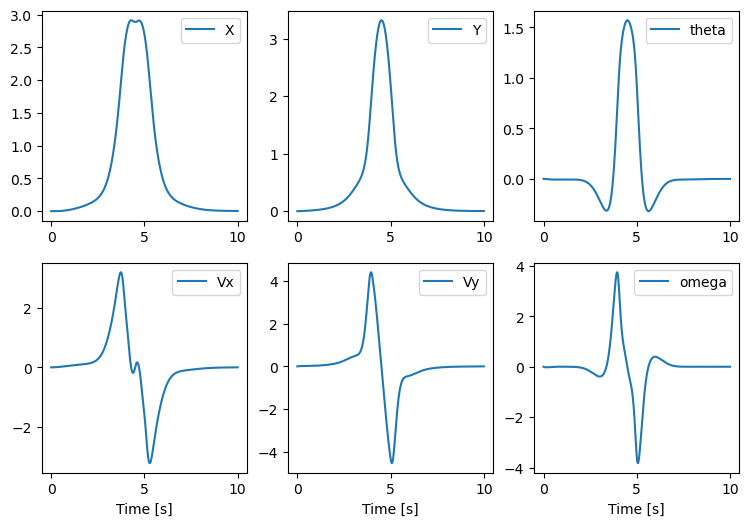

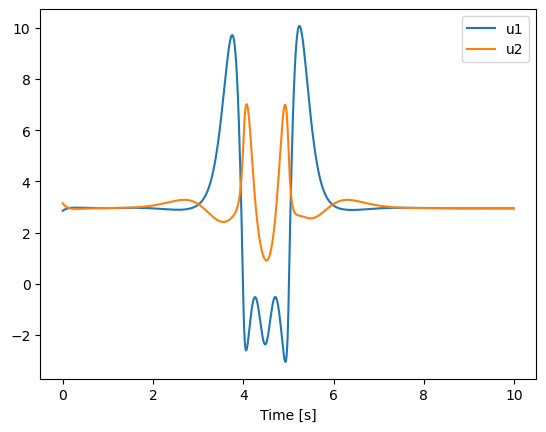

In [16]:
plt.figure(figsize=[9,6])
t=np.arange(0,10.01,0.01)
plt.subplot(2,3,1)
plt.plot(t, state[0,:])
plt.legend(['X'])

plt.subplot(2,3,2)
plt.plot(t, state[2,:])
plt.legend(['Y'])

plt.subplot(2,3,3)
plt.plot(t, state[4,:])
plt.legend(["theta"])

plt.subplot(2,3,4)
plt.plot(t, state[1,:])
plt.legend(['Vx'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state[3,:])
plt.legend(['Vy'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state[5,:])
plt.legend(['omega'])
plt.xlabel('Time [s]')

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1', 'u2'])
plt.xlabel('Time [s]')
